# Structural Econometrics - Assignment 2 Tutorial
### Author: Jaepil Lee
### Date: 11/1/2021

I thank Christine Dabbs and Martin Michelini for their help and comments.

### [How GMM works: OLS and LIV](#ols_liv_GMM)<a name="ols_liv_GMM_menu"></a>
### [Model](#review)<a name="review_menu"></a>
### [Data](#data)<a name="data_menu"></a>
### [Estimation](#estimation)<a name="estimation_menu"></a>

We aim to replicate a table below by using **monthly data** from 1960-1 to 2020-12.

Note: The panels of Table III that this assignment asks you to replicate appear in their errata published in 1984.

<img src="[Hansen,Singleton;1984;Ecma] ERRATA - Table III estimates with multiple returns.png">

In [1]:
ENV["COLUMNS"]=100; ENV["LINES"]=1000
# Importing packages...
using Pkg; Pkg.activate("./.."); Pkg.instantiate();
using Distributions, Statistics, Random, HypothesisTests,
      LinearAlgebra, Distances, SharedArrays, 
      Optim, ForwardDiff, NLSolversBase, 
      Plots, Printf, LaTeXStrings, PlotThemes,
      CSV, DataFrames, TimeSeries, Dates,
      FredApi, FredData;

  Activating project at `c:\Users\jaepi\OneDrive\Documents\GitHub\jaepillee0315.github.io`


## [How GMM works: OLS and LIV](#ols_liv_GMM)<a name="ols_liv_GMM_menu"></a>

Let's first see how GMM estimation routine works in OLS and LIV. Let's construct a hypothetical dataset with $N$ where:
- $y_i = \beta_0 + \beta_1 x_{i,1} + \beta_2 x_{i,2} + \varepsilon_i, \varepsilon_i \sim \mathcal{N}(0,\sigma^2)$ for $i=1,\ldots,N$
- $(\beta_0, \beta_1, \beta_2) = (0.15, 0.25, -1.5), \sigma = 1.2$

We all know what $\beta_{ols}$ looks like: $(X'X)^{-1}X'Y$. We also know its standard errors. Let's code it just for fun:

In [2]:
#%% DGP
function DGP_OLS(N, β_DGP, σ_DGP)
    Random.seed!(42) # RNG: We get the same number for replicability
    (β₀,β₁,β₂) = β_DGP
    x₁ = randn(N) # a Nx1 vector
    x₂ = randn(N) # a Nx1 vector
    ε = σ_DGP * randn(N)  # a Nx1 vector
    y = β₀ .+ β₁ .* x₁ .+ β₂ .* x₂ .+ ε # a Nx1 vector
    X = [ones(N, 1) x₁ x₂] # a Nx3 matrix
    # If you wish to use other statistical packages, use this CSV file.
    # df = DataFrame(X0 = X[:, 1], X1 = X[:, 2], X2 = X[:, 3], y = y);
    # CSV.write("./OLS.csv",df);
    return y, X
end
#%% OLS estimation
function OLS_estimation(y, X)
    N = length(y)
    β_OLS = inv(X'X) * X'y # a 3x1 vector given DGP
    ε_OLS = y - X * β_OLS
    invXX = inv(X'*X)
    Xε = X.*ε_OLS
    Σ_OLS = invXX*(Xε'*Xε)*invXX # V_HC0 - White-Heteroskedasticity-Robust VCov
    σ_OLS = sqrt.(diag(Σ_OLS))
    return β_OLS, σ_OLS
end;

Let's take $\mathbf{Y}$ and $\mathbf{X}$ we generated above and find $\beta$ via GMM. You will see that they are exactly equal to each other. Let $f_i(\beta):=f(Y_i,X_i,\beta)$ be the function of orthogonality conditions evaluated at $i$'s covariates. The orthogonality condition for OLS is $\mathbb{E}(\varepsilon_i X_i) = 0$, where $\varepsilon_i = Y_i - X_i'\beta$ and the expectation is taken over $i$. In the GMM framework, we wish to find $\beta$ that satisfies:
$$
    0 = \frac{1}{N}\sum_{i=1}^{N}f_i(\beta) = \frac{1}{N}\sum_{i=1}^{N} \varepsilon_i X_i= \frac{1}{N}\sum_{i=1}^{N} (Y_i - X_i'\beta) \times X_i.
$$
Notice there are $3 \times 1$ orthogonality conditions: $\varepsilon_i$ is a scalar and $X_i$ is a $3\times1$ vector. Thus, the above equation is an "element-wise" average of a vector-valued function.

If you recall from econometrics I, what OLS really does is minimizing the sum of squared residuals, $\frac{1}{N}\sum_{i=1}^N \varepsilon_i^2$ where $\varepsilon_i=Y_i-X_i'\beta$. The first order condition of the minimization problem is found by taking a gradient of the sum of squared residuals (as a function of $\beta$, $X$, and $Y$) with respect to $\beta$. 
$$
    \frac{\partial}{\partial\beta'}\left(\frac{1}{N}\sum_{i}^{N}Y_i^2 - \frac{1}{N}\sum_{i}^{N} 2 X_i Y_i \beta + \frac{1}{N}\sum_{i}^{N} \beta' X_i X_i' \beta \right) = \frac{1}{N}\sum_{i}^{N}2(X_iX_i'\beta - X_i Y_i) = 0 \\
    \frac{1}{N}\sum_{i}^{N}(Y_i - X_i'\beta) \times X_i = 0
$$
This is exactly equal to the moment that GMM uses.

In [3]:
# OLS via GMM
function GMM_OLS(y,X)

    #=
    f_OLS(β,y,X): orthogonality conditions
    W: weighting matrix. In OLS, this is the identity matrix.
    f_sum(β): a (k x 1) vector of sample average of normal function.
    obj_OLS(β): a "sandwich" of f_sum(β).
    Q: In OLS, it is inv(X'*X).
    Ω: In OLS, it is the outer product of (X'*ε).
    =#

    function f_OLS(β,y,X)
        return (y - X*β) .* X
    end
    
    k = size(X)[2]
    N = length(y)
    W = I;
    f_sum(β) = vec(sum(f_OLS(β, y, X),dims=1));
    obj_OLS(β) = N * (f_sum(β)/N)' * W * (f_sum(β)/N);
    opt = optimize(obj_OLS, randn(k), BFGS(), autodiff = :forward);

    β_OLS_GMM = opt.minimizer;
    Q = ForwardDiff.jacobian(β -> f_sum(β) , β_OLS_GMM)/N;
    Ω = f_OLS(β_OLS_GMM, y, X)'*f_OLS(β_OLS_GMM, y, X)/N;
    Σ_OLS_GMM = inv(Q'*W*Q)*(Q'*W*Ω*W*Q)*inv(Q'*W*Q)/N; # remember to divide by N to compute s.e. of β_hat!
    σ_OLS_GMM = sqrt.(diag(Σ_OLS_GMM));
    
    return β_OLS_GMM, σ_OLS_GMM

end;

In [4]:
#%% Simulation & Estimation
N = 100_000
β_DGP = (0.15,0.25,-1.5)
σ_DGP = 1.2
y_OLS, X_OLS = DGP_OLS(N, β_DGP, σ_DGP)
β_OLS, σ_OLS = OLS_estimation(y_OLS, X_OLS);
β_OLS_GMM, σ_OLS_GMM = GMM_OLS(y_OLS,X_OLS);

# Print the results
print("Using the formula for OLS:\n")
print("    |     β₀     |     β₁     |     β₂     | \n")
@printf("DGP | %10.7f | %10.7f | %10.7f |\n", β_DGP[1], β_DGP[2], β_DGP[3])
@printf("OLS | %10.7f | %10.7f | %10.7f |\n", β_OLS[1], β_OLS[2], β_OLS[3])
@printf("    |(%10.7f)|(%10.7f)|(%10.7f)|\n", σ_OLS[1], σ_OLS[2], σ_OLS[3])
@printf("GMM | %10.7f | %10.7f | %10.7f |\n", β_OLS_GMM[1], β_OLS_GMM[2], β_OLS_GMM[3])
@printf("    |(%10.7f)|(%10.7f)|(%10.7f)|\n", σ_OLS_GMM[1], σ_OLS_GMM[2], σ_OLS_GMM[3])
print("Standard errors in parentheses.")

Using the formula for OLS:
    |     β₀     |     β₁     |     β₂     | 
DGP |  0.1500000 |  0.2500000 | -1.5000000 |
OLS |  0.1420908 |  0.2535708 | -1.5015455 |
    |( 0.0037943)|( 0.0037934)|( 0.0038091)|
GMM |  0.1420908 |  0.2535708 | -1.5015455 |
    |( 0.0037943)|( 0.0037934)|( 0.0038091)|
Standard errors in parentheses.

As we expect, OLS and GMM estimation give us the same estimates.

Let's scale up a little bit and do LIV. 2SLS in the over-identified case is what we will use in GMM.

Let $f_i(\beta):=f(Y_i,X_i,Z_i,\beta)$ be the function of orthogonality conditions. The orthogonality condition for LIV is $\mathbb{E}(\varepsilon_i Z_i) = 0$, where $\varepsilon_i = Y_i - X_i'\beta$ and the expectation is taken over $i$. In the GMM framework, we wish to find $\beta$ that satisfies below:
$$
    0 = \frac{1}{N}\sum_{i=1}^{N}f_i(\beta) = \frac{1}{N}\sum_{i=1}^{N} \varepsilon_i Z_i= \frac{1}{N}\sum_{i=1}^{N} (Y_i - X_i'\beta) \times Z_i.
$$

If we have more instruments than the number of endogenous variables, we call the model is over-identified. In the example below, I set $x_2$ to be the endogenous variable and provide 2 instruments, $z_1$ and $z_2$. If we use both $z_1$ and $z_2$, then we have 4 orthogonality conditions and 3 parameters to estimate. It is almost surely impossible to find $\beta$ where the moment is zero. Thus, we just find $\beta$ that makes the moment as close to zero as possible. We instead can introduce some positive definite weighting matrix $W$ and make the estimate more efficient.

In [5]:
# DGP for LIV
function DGP_LIV(N, β_DGP,μ,Σ)
     Random.seed!(42)
     (β₀,β₁,β₂) = β_DGP
     (x₂, z₁, z₂, ε) = collect.(eachrow(rand(MvNormal(μ,Σ),N)))
     x₁ = randn(N)
     y = β₀ .+ β₁*x₁ .+ β₂*x₂ .+ ε # a Nx1 vector
     X = [x₁ x₂] # a Nx2 matrix
     Z = [z₁ z₂]
     return y, X, Z
end;

In [6]:
function LIV_estimation(y, X_data, Z)

     N = length(y)
     X      = [ones(N) X_data]
     X₁Z₁   = [ones(N) X[:,2] Z[:,1]]
     X₁Z₂   = [ones(N) X[:,2] Z[:,2]]
     X₁Z_oi = [ones(N) X[:,2] Z[:,1] Z[:,2]] # over-identified case
 
     # Naive OLS produces biased estimates
     β_IV_OLS  = inv(X'*X) * X'*y # a 3x1 vector
     ε_OLS = y - X * β_IV_OLS
     invXX = inv(X'*X)
     Xε = X.*ε_OLS
     Σ_IV_OLS = invXX*(Xε'*Xε)*invXX # V_HC0 - White-Heteroskedasticity-Robust VCov
     σ_IV_OLS = sqrt.(diag(Σ_IV_OLS))

     # Using Z₁ as instrument
     # β_IV_Z₁ = inv(X'*X₁Z₁)*(X₁Z₁'*y)
     # ε_IV_Z₁ = y - X * β_IV_Z₁
     # invXZ₁  = inv(X'*X₁Z₁)
     # Z₁ε     = X₁Z₁.*ε_IV_Z₁
     # Σ_IV_Z₁ = invXZ₁*(Z₁ε'*Z₁ε)*invXZ₁
     # σ_IV_Z₁ = sqrt.(diag(Σ_IV_Z₁))

     # Using Z₂ as instrument
     # β_IV_Z₂ = inv(X'*X₁Z₂)*(X₁Z₂'*y)
     # ε_IV_Z₂ = y - X * β_IV_Z₂
     # invXZ₂  = inv(X'*X₁Z₂)
     # Z₂ε     = X₁Z₂.*ε_IV_Z₂
     # Σ_IV_Z₂ = invXZ₂*(Z₂ε'*Z₂ε)*invXZ₂
     # σ_IV_Z₂ = sqrt.(diag(Σ_IV_Z₂))

     # 2SLS - Using Z₁ as instrument
     β_2SLS_Z₁  = inv(X'*X₁Z₁*inv(X₁Z₁'*X₁Z₁)*X₁Z₁'*X)*X'*X₁Z₁*inv(X₁Z₁'*X₁Z₁)*X₁Z₁'*y
     ε_2SLS_Z₁  = y - X * β_2SLS_Z₁
     Zε_2SLS_Z₁ = X₁Z₁.*ε_2SLS_Z₁
     Qxz₁  = X'*X₁Z₁
     Qz₁z₁ = X₁Z₁'*X₁Z₁
     Qz₁x  = X₁Z₁'*X
     Ω_2SLS_Z₁ = Zε_2SLS_Z₁'*Zε_2SLS_Z₁
     Σ_2SLS_Z₁ = inv(Qxz₁*inv(Qz₁z₁)*Qz₁x)*(Qxz₁*inv(Qz₁z₁)*Ω_2SLS_Z₁*inv(Qz₁z₁)*Qz₁x)*inv(Qxz₁*inv(Qz₁z₁)*Qz₁x)
     σ_2SLS_Z₁ =sqrt.(diag(Σ_2SLS_Z₁))

     # 2SLS - Using Z₂ as instrument
     # β_2SLS_Z₂  = inv(X'*X₁Z₁*inv(X₁Z₁'*X₁Z₁)*X₁Z₁'*X)*X'*X₁Z₁*inv(X₁Z₁'*X₁Z₁)*X₁Z₁'*y
     # ε_2SLS_Z₂  = y - X * β_2SLS_Z₂
     # Zε_2SLS_Z₂ = X₁Z₂.*ε_2SLS_Z₂
     # Qxz₂  = X'*X₁Z₂
     # Qz₂z₂ = X₁Z₂'*X₁Z₂
     # Qz₂x  = X₁Z₂'*X
     # Ω_2SLS_Z₂ = Zε_2SLS_Z₂'*Zε_2SLS_Z₂
     # Σ_2SLS_Z₂ = inv(Qxz₂*inv(Qz₂z₂)*Qz₂x)*(Qxz₂*inv(Qz₂z₂)*Ω_2SLS_Z₂*inv(Qz₂z₂)*Qz₂x)*inv(Qxz₂*inv(Qz₂z₂)*Qz₂x)
     # σ_2SLS_Z₂ =sqrt.(diag(Σ_2SLS_Z₂))

     # Using Z₁ and Z₂ as instrument: OVERIDENTIFIED!
     Qxz = X'*X₁Z_oi
     Qzz = X₁Z_oi'*X₁Z_oi
     Qzx = X₁Z_oi'*X
     β_2SLS_oi = inv(Qxz*inv(Qzz)*Qzx)*(Qxz*inv(Qzz)*X₁Z_oi')*y
     ε_2SLS_oi = y - X*β_2SLS_oi
     Zε = X₁Z_oi.*ε_2SLS_oi
     Ω_2SLS_oi = Zε'*Zε
     Σ_2SLS_oi= inv(Qxz*inv(Qzz)*Qzx)*(Qxz*inv(Qzz)*Ω_2SLS_oi*inv(Qzz)*Qzx)*inv(Qxz*inv(Qzz)*Qzx)
     σ_2SLS_oi=sqrt.(diag(Σ_2SLS_oi))

     # β_IV_Z₁,   σ_IV_Z₁,
     # β_IV_Z₂,   σ_IV_Z₂,
     # β_2SLS_Z₁, σ_2SLS_Z₁,
     # β_2SLS_Z₂, σ_2SLS_Z₂,

     return β_IV_OLS, σ_IV_OLS, β_2SLS_Z₁, σ_2SLS_Z₁, β_2SLS_oi, σ_2SLS_oi
end;

In [7]:
# order: x₂, Z₁, Z₂, ε
μ = [0.0; 0.0; 0.0; 0.0];
Σ = [2.0  0.5  -.5  1.0;
     0.5  1.0  0.5  0.0;
     -.5  0.5  1.0  0.0;
     1.0  0.0  0.0  2.0];
Y_LIV, X_LIV, Z_LIV = DGP_LIV(N, β_DGP,μ,Σ);
β_IV_OLS, σ_IV_OLS, β_2SLS_Z₁, σ_2SLS_Z₁, β_2SLS_oi, σ_2SLS_oi = LIV_estimation(Y_LIV, X_LIV, Z_LIV);

print("LIV result: β₂ is biased in OLS \n")
print("        |     β₀     |     β₁     |     β₂     | \n")
@printf("DGP     | %10.7f | %10.7f | %10.7f |\n", β_DGP[1], β_DGP[2], β_DGP[3])
@printf("OLS     | %10.7f | %10.7f | %10.7f |\n", β_IV_OLS[1], β_IV_OLS[2], β_IV_OLS[3])
@printf("        |(%10.7f)|(%10.7f)|(%10.7f)|\n", σ_OLS[1], σ_OLS[2], σ_OLS[3])
#@printf("IV-Z₁   | %10.7f | %10.7f | %10.7f |\n", β_IV_Z₁[1], β_IV_Z₁[2], β_IV_Z₁[3])
#@printf("        |(%10.7f)|(%10.7f)|(%10.7f)|\n", σ_IV_Z₁[1], σ_IV_Z₁[2], σ_IV_Z₁[3])
#@printf("IV-Z₂   | %10.7f | %10.7f | %10.7f |\n", β_IV_Z₂[1], β_IV_Z₂[2], β_IV_Z₂[3])
#@printf("        |(%10.7f)|(%10.7f)|(%10.7f)|\n", σ_IV_Z₂[1], σ_IV_Z₂[2], σ_IV_Z₂[3])
@printf("2SLS-Z₁ | %10.7f | %10.7f | %10.7f |\n", β_2SLS_Z₁[1], β_2SLS_Z₁[2], β_2SLS_Z₁[3])
@printf("        |(%10.7f)|(%10.7f)|(%10.7f)|\n", σ_2SLS_Z₁[1], σ_2SLS_Z₁[2], σ_2SLS_Z₁[3])
#@printf("2SLS-Z₂ | %10.7f | %10.7f | %10.7f |\n", β_2SLS_Z₂[1], β_2SLS_Z₂[2], β_2SLS_Z₂[3])
#@printf("        |(%7.4f)|(%7.4f)|(%7.4f)|\n", σ_2SLS_Z₂[1], σ_2SLS_Z₂[2], σ_2SLS_Z₂[3])
@printf("2SLS-oi | %10.7f | %10.7f | %10.7f |\n", β_2SLS_oi[1], β_2SLS_oi[2], β_2SLS_oi[3])
@printf("        |(%10.7f)|(%10.7f)|(%10.7f)|\n", σ_2SLS_oi[1], σ_2SLS_oi[2], σ_2SLS_oi[3])
print("Standard errors in parentheses.")

LIV result: β₂ is biased in OLS 
        |     β₀     |     β₁     |     β₂     | 
DGP     |  0.1500000 |  0.2500000 | -1.5000000 |
OLS     |  0.1528256 |  0.2466338 | -1.0007642 |
        |( 0.0037943)|( 0.0037934)|( 0.0038091)|
2SLS-Z₁ |  0.1549376 |  0.2459761 | -1.4868146 |
        |( 0.0044358)|( 0.0044068)|( 0.0087746)|
2SLS-oi |  0.1549913 |  0.2459594 | -1.4991842 |
        |( 0.0044629)|( 0.0044338)|( 0.0044755)|
Standard errors in parentheses.

You can see that LIV estimate for $\beta_2$ in over-identified case has smaller standard error compared to just-identified case. Motivated by these examples, let's take a look at what GMM does:

#### Definition ([Bruce Hansen, p.416](https://www.ssc.wisc.edu/~bhansen/econometrics/Econometrics.pdf))
Let $\beta$ be a $k\times1$ vector, $f_i(\beta)$ be a $l\times1$ orthogonality conditions, and $W$ be a $l\times l$ positive definite weighting matrix. Define the GMM criterion function $J(\beta)$ as
$$
    J(\beta) = N \left(\frac{1}{N}\sum_{i=1}^N f_i(\beta)\right)' W \left(\frac{1}{N}\sum_{i=1}^N f_i(\beta)\right).
$$
The GMM estimator is 
$$
    \hat{\beta}_{gmm} = \underset{\beta}{\arg\min}\; J(\beta).
$$

#### Proposition ([Bruce Hansen, p.432](https://www.ssc.wisc.edu/~bhansen/econometrics/Econometrics.pdf))
Under general regularity conditions, $\sqrt{N}(\hat{\beta}_{gmm}-\beta_0) \xrightarrow[]{d} N(0,V_\beta)$ where 
$$
\begin{align*}
    V_\beta &= (Q'WQ)^{-1}(Q'W\Omega WQ)(Q'WQ)^{-1}\\
    \Omega &= \mathbb{E}(f_i f_i') \\
    Q &= \mathbb{E}\left[\frac{\partial}{\partial \beta'}f_i(\beta)\right].
\end{align*}
$$
If $W$ is efficient, $V_\beta = (Q'\Omega^{-1} Q)^{-1}$.

Note that when you compute standard errors for $\hat{\beta}_{gmm}$, you must divide $V_\beta$ by $N$! $V_\beta$ is the variance for $\sqrt{N}(\hat{\beta}_{gmm}-\beta)$, not $\hat{\beta}_{gmm}$ .

#### Two-step GMM ([Bruce Hansen, p.444](https://www.ssc.wisc.edu/~bhansen/econometrics/Econometrics.pdf))
In order to construct the efficient GMM estimator, we need to know what is the optimal $W$ in our model. In LIV, we know that $W=(Z'Z)^{-1}$. If the optimal weighting matrix $W=\Omega^{-1}$ is unknown, then we can first estimate $W$ with a standard GMM routine (say, by setting $W=I$), and then do the GMM routine again with $W=\hat{\Omega}^{-1}$.

#### Programming
In this case, we can simply code GMM as follows:
1. Set some weighting matrix $W$. In our example, for the just-identified case, use $W=I$ and for the over-identified case, use $W=(Z'Z)^{-1}$.
1. Construct the GMM criterion function. It is **obj_IV** in my code.
1. Ask the computer to minimize the criterion function for you. The minimizer is your $\hat{\beta}_{gmm}$.
1. Compute $Q$ and $\Omega$.
    - If you are using a two-step GMM, then repeat step 3 and 4 by setting $W=\hat{\Omega}^{-1}$
1. Compute the asymptotic variance $V_\beta$. 
1. Compute standard errors with $\textbf{sqrt}.(\textbf{diag}(\mathbf{V_\beta}/N))$

In [8]:
#%% GMM_IV
function GMM_one_step(y,Z_data,X_data;W=I)

    #=
    f_IV(β, y, Z, X): orthogonality conditions
    W: the weighting matrix. In one-step GMM, we do not update this.
    =#
   
    N = length(y)
    X = [ones(N) X_data]
    Z = [ones(N) X_data[:,1] Z_data]
    k = size(X)[2] # size of β
    
    function f_IV(β, y, Z, X)
        return (y - X*β) .* Z # (N×1) * (N×4)
    end
    
    f_sum_IV(β) = vec(sum(f_IV(β, y, Z, X),dims=1));
    obj_IV(β) = N * (f_sum_IV(β)/N)' * W * (f_sum_IV(β)/N);
    opt = optimize(obj_IV, randn(k), BFGS(), autodiff = :forward);
    β_GMM = opt.minimizer
    Q = ForwardDiff.jacobian(β -> f_sum_IV(β) , β_GMM)/N;
    Ω = f_IV(β_GMM, y, Z, X)'*f_IV(β_GMM, y, Z, X)/N;
    V_GMM = inv(Q'*W*Q)*(Q'*W*Ω*W*Q)*inv(Q'*W*Q)/N; # remember to divide by N!
    σ_GMM = sqrt.(diag(V_GMM))

    return β_GMM, σ_GMM

end;

In [9]:
function GMM_two_step(y,Z_data,X_data)

    #=
    f_IV(β, y, Z, X): orthogonality conditions
    W: the weighting matrix. In this case, we update this once.
    =#

    N = length(y)
    X = [ones(N) X_data]
    Z = [ones(N) X_data[:,1] Z_data]
    k = size(X)[2] # size of β
    
    function f_IV(β, y, Z, X)
        return (y - X*β) .* Z # (N×1) * (N×4)
    end
    f_sum_IV(β) = vec(sum(f_IV(β, y, Z, X),dims=1));
    
    # First-step: the estimates and the standard errors are the same as setting W=I in one-step GMM.
    W_1 = I;
    obj_GMM_1(β) = N * (f_sum_IV(β)/N)' * W_1 * (f_sum_IV(β)/N);
    opt_1 = optimize(obj_GMM_1, randn(k), BFGS(), autodiff = :forward);
    β_GMM_1 = opt_1.minimizer
    Q_1 = ForwardDiff.jacobian(β -> f_sum_IV(β) , β_GMM_1)/N;
    Ω_1 = f_IV(β_GMM_1, y, Z, X)'*f_IV(β_GMM_1, y, Z, X)/N;

    # Second-step
    W_opt = inv(Ω_1)
    obj_GMM_2(β) = N * (f_sum_IV(β)/N)' * W_opt * (f_sum_IV(β)/N);
    opt_2 = optimize(obj_GMM_2, randn(k), BFGS(), autodiff = :forward);
    β_GMM_2 = opt_2.minimizer
    Q_2 = ForwardDiff.jacobian(β -> f_sum_IV(β) , β_GMM_2)/N;
    Ω_2 = f_IV(β_GMM_2, y, Z, X)'*f_IV(β_GMM_2, y, Z, X)/N;
    
    # Results
    V_GMM_1 = inv(Q_1'*W_1*Q_1)*(Q_1'*W_1*Ω_1*W_1*Q_1)*inv(Q_1'*W_1*Q_1)/N; # remember to divide by N!
    σ_GMM_1 = sqrt.(diag(V_GMM_1))
    V_GMM_2 = inv(Q_2'*W_opt*Q_2)*(Q_2'*W_opt*Ω_2*W_opt*Q_2)*inv(Q_2'*W_opt*Q_2)/N; # remember to divide by N!
    σ_GMM_2 = sqrt.(diag(V_GMM_2))

    return β_GMM_1, σ_GMM_1, β_GMM_2, σ_GMM_2

end;

In [10]:
# Estimation
Z = [ones(N) X_LIV[:,1] Z_LIV];
β_GMM_I,  σ_GMM_I      = GMM_one_step(Y_LIV,Z_LIV,X_LIV,W=I);
β_GMM_ZZ, σ_GMM_ZZ     = GMM_one_step(Y_LIV,Z_LIV,X_LIV,W=inv(Z'*Z));
_, _, β_GMM_2, σ_GMM_2 = GMM_two_step(Y_LIV,Z_LIV,X_LIV);

# Print the results
print("GMM result, overidentified: β₂ is biased in OLS \n")
print("              |     β₀    |     β₁    |     β₂    | \n")
@printf("DGP           | %10.7f | %10.7f | %10.7f |\n", β_DGP[1], β_DGP[2], β_DGP[3])
@printf("One-step GMM: | %10.7f | %10.7f | %10.7f |\n", β_GMM_I[1], β_GMM_I[2], β_GMM_I[3])
@printf(" W=I          |(%10.7f)|(%10.7f)|(%10.7f)|\n", σ_GMM_I[1], σ_GMM_I[2], σ_GMM_I[3])
@printf("One-step GMM: | %10.7f | %10.7f | %10.7f |\n", β_GMM_ZZ[1], β_GMM_ZZ[2], β_GMM_ZZ[3])
@printf(" W=inv(Z'Z)   |(%10.7f)|(%10.7f)|(%10.7f)|\n", σ_GMM_ZZ[1], σ_GMM_ZZ[2], σ_GMM_ZZ[3])
@printf("Two-step GMM  | %10.7f | %10.7f | %10.7f |\n", β_GMM_2[1], β_GMM_2[2], β_GMM_2[3])
@printf("              |(%10.7f)|(%10.7f)|(%10.7f)|\n", σ_GMM_2[1], σ_GMM_2[2], σ_GMM_2[3])
print("Standard errors in parentheses.")

GMM result, overidentified: β₂ is biased in OLS 
              |     β₀    |     β₁    |     β₂    | 
DGP           |  0.1500000 |  0.2500000 | -1.5000000 |
One-step GMM: |  0.1550011 |  0.2459534 | -1.4990387 |
 W=I          |( 0.0044626)|( 0.0044335)|( 0.0044756)|
One-step GMM: |  0.1549913 |  0.2459594 | -1.4991842 |
 W=inv(Z'Z)   |( 0.0044629)|( 0.0044338)|( 0.0044755)|
Two-step GMM  |  0.1550008 |  0.2460098 | -1.4991458 |
              |( 0.0044628)|( 0.0044336)|( 0.0044754)|
Standard errors in parentheses.

There is small difference between two-step GMM and One-step GMM with $W=(Z'Z)^{-1}$ because two-step GMM estimated $W$. As you increase $N$, this difference will disappear.

One could also iterate steps as many times as you wish until the updated $\hat{\beta}_{gmm}$ converges. This is called **Iterated GMM**. Note, however, the two-step GMM is already asymptotically efficient. You might want to use iterated GMM if you think the estimates are suffering from small sample.

#### Programming
1. Set some weighting matrix $W$. In our example, for the just-identified case, use $W=I$ and for the over-identified case, use $W=(Z'Z)^{-1}$. Also, set some tolerance to declare 'convergence'.
1. Construct the GMM criterion function. It is **obj_IV** in my code.
1. Ask the computer to minimize the criterion function for you. The minimizer is your $\hat{\beta}_{gmm}$.
1. Compute $Q$ and $\Omega$.
    - Repeat step 3 and 4 by updating $W=\hat{\Omega}^{-1}$ iteratively and until convergence up to some tolerance.
1. Compute the asymptotic variance $V_\beta$. 
1. Compute standard errors with $\textbf{sqrt}.(\textbf{diag}(\mathbf{V_\beta}/N))$.

In [11]:
function iterated_GMM(func, γ, y, X, Z; tol=0.001, max_iter=10)

    #=
    func: moment(s)
    X: the matrix of variables that forms moments we wish to make 0
    Z: the matrix orthogonal to moment
    tol: if diff<tol, we claim the update converged
    max_iter: if iter>max_iter, we stop and report what we have so far.
    If max_iter = 2, then it is equivalent to two-step GMM.
    =#

    γ_GMM    = Vector{Vector{Float64}}()
    σ_GMM    = Vector{Vector{Float64}}()
    chi2_vec = Vector{Float64}()
    pval_vec = Vector{Float64}()
    diff_vec = Vector{Float64}()

    N  = size(func(γ, y, X, Z))[1];
    l  = size(func(γ, y, X, Z))[2];
    k  = length(γ);
    df = l-k

    func_vec(γ) = vec(sum(func(γ, y, X, Z),dims=1));

    # First step
    W_1 = I;
    obj_GMM_1(γ) = N * (func_vec(γ)/N)' * W_1 * (func_vec(γ)/N);
    opt_1 = optimize(obj_GMM_1, randn(k), BFGS(), autodiff = :forward);
    γ_GMM_1 = vec(opt_1.minimizer)
    Q_1 = ForwardDiff.jacobian(γ -> func_vec(γ) , γ_GMM_1)/N;
    Ω_1 = func(γ_GMM_1, y, X, Z)'*func(γ_GMM_1, y, X, Z)/N;
    V_GMM_1 = inv(Q_1'*W_1*Q_1)*(Q_1'*W_1*Ω_1*W_1*Q_1)*inv(Q_1'*W_1*Q_1)/N; # remember to divide by N!
    σ_GMM_1 = sqrt.(diag(V_GMM_1))
    chi2 = obj_GMM_1(γ_GMM_1)
    pval = ccdf(Chisq(l-k),obj_GMM_1(γ_GMM_1)) # p-val

    push!(γ_GMM, γ_GMM_1)
    push!(σ_GMM, σ_GMM_1)
    push!(chi2_vec, chi2)
    push!(pval_vec, pval)

    diff = 1e6
    iter = 1
    
    # Iterated GMM
    while (diff > tol) & (iter < max_iter)
        W_opt = inv(Ω_1)
        obj_GMM_2(γ) = N * (func_vec(γ)/N)' * W_opt * (func_vec(γ)/N);
        opt_2 = optimize(obj_GMM_2, randn(k), BFGS(), autodiff = :forward);
        γ_GMM_2 = vec(opt_2.minimizer)
        Q_2 = ForwardDiff.jacobian(γ -> func_vec(γ) , γ_GMM_2)/N;
        Ω_2 = func(γ_GMM_2, y, X, Z)'*func(γ_GMM_2, y, X, Z)/N;
        V_GMM_2 = inv(Q_2'*W_opt*Q_2)*(Q_2'*W_opt*Ω_2*W_opt*Q_2)*inv(Q_2'*W_opt*Q_2)/N; # remember to divide by N!
        σ_GMM_2 = sqrt.(diag(V_GMM_2));
        chi2 = obj_GMM_2(γ_GMM_2)    
        pval = ccdf(Chisq(l-k),obj_GMM_2(γ_GMM_2)) # p-val

        # update
        diff = sqrt(sum((γ_GMM_2-γ_GMM_1).^2))
        Ω_1 = Ω_2
        γ_GMM_1 = γ_GMM_2
        iter += 1

        # record
        push!(diff_vec, diff)
        push!(γ_GMM, γ_GMM_2)
        push!(σ_GMM, σ_GMM_2)
        push!(chi2_vec, chi2)
        push!(pval_vec, pval)
    end

    return γ_GMM, σ_GMM, chi2_vec, df, pval_vec, diff_vec
    
end;

In [12]:
# Estimation
Z = [ones(N) X_LIV[:,1] Z_LIV];
β_GMM_I,  σ_GMM_I      = GMM_one_step(Y_LIV,Z_LIV,X_LIV,W=I);
β_GMM_ZZ, σ_GMM_ZZ     = GMM_one_step(Y_LIV,Z_LIV,X_LIV,W=inv(Z'*Z));
_, _, β_GMM_2, σ_GMM_2 = GMM_two_step(Y_LIV,Z_LIV,X_LIV);
# Iterated GMM 
function f_IV(β, y, Xdata, Zdata)
    N = length(y)
    X = [ones(N) Xdata]
    Z = [ones(N) Xdata[:,1] Zdata]
    return (y - X*β) .* Z # (N×1) * (N×4)
end
β_GMM_iter, σ_GMM_iter, chi2_vec, df, pval_vec, diff_vec = iterated_GMM(f_IV, randn(3), Y_LIV, X_LIV, Z_LIV; tol=1e-9, max_iter=5);

In [13]:
# Print the results
print("Iterated GMM result, overidentified: β₂ is biased in OLS \n")
print("        |     β₀     |     β₁     |     β₂     | \n")
@printf("DGP     | %10.7f | %10.7f | %10.7f |\n", β_DGP[1], β_DGP[2], β_DGP[3])
@printf("Step 1  | %10.7f | %10.7f | %10.7f |\n", β_GMM_iter[1][1], β_GMM_iter[1][2], β_GMM_iter[1][3])
@printf("        |(%10.7f)|(%10.7f)|(%10.7f)|\n", σ_GMM_iter[1][1], σ_GMM_iter[1][2], σ_GMM_iter[1][3])
@printf("Step 2  | %10.7f | %10.7f | %10.7f |\n", β_GMM_iter[2][1], β_GMM_iter[2][2], β_GMM_iter[2][3])
@printf("        |(%10.7f)|(%10.7f)|(%10.7f)|\n", σ_GMM_iter[2][1], σ_GMM_iter[2][2], σ_GMM_iter[2][3])
@printf("Step 3  | %10.7f | %10.7f | %10.7f |\n", β_GMM_iter[3][1], β_GMM_iter[3][2], β_GMM_iter[3][3])
@printf("        |(%10.7f)|(%10.7f)|(%10.7f)|\n", σ_GMM_iter[3][1], σ_GMM_iter[3][2], σ_GMM_iter[3][3])
@printf("Step 4  | %10.7f | %10.7f | %10.7f |\n", β_GMM_iter[4][1], β_GMM_iter[4][2], β_GMM_iter[4][3])
@printf("        |(%10.7f)|(%10.7f)|(%10.7f)|\n", σ_GMM_iter[4][1], σ_GMM_iter[4][2], σ_GMM_iter[4][3])
print("Standard errors in parentheses.")

Iterated GMM result, overidentified: β₂ is biased in OLS 
        |     β₀     |     β₁     |     β₂     | 
DGP     |  0.1500000 |  0.2500000 | -1.5000000 |
Step 1  |  0.1550011 |  0.2459534 | -1.4990387 |
        |( 0.0044626)|( 0.0044335)|( 0.0044756)|
Step 2  |  0.1550008 |  0.2460098 | -1.4991458 |
        |( 0.0044628)|( 0.0044336)|( 0.0044754)|
Step 3  |  0.1550008 |  0.2460098 | -1.4991458 |
        |( 0.0044628)|( 0.0044336)|( 0.0044754)|
Step 4  |  0.1550008 |  0.2460098 | -1.4991458 |
        |( 0.0044628)|( 0.0044336)|( 0.0044754)|
Standard errors in parentheses.

## [Review model](#review_menu)<a name="review"></a>

We consider the following model
$$
    1=\mathbb{E}_{t}\left[r_{t+1, k} \beta \frac{u^{\prime}\left(c_{t+1}\right)}{u^{\prime}\left(c_{t}\right)}\right] \equiv \mathbb{E}_{t}\left[r_{t+1, k} MRS_{t+1}\right]
$$
where:
- $r_{t+1,k}$ is gross real return on asset $k$
- $\beta \frac{u^{\prime}\left(c_{t+1}\right)}{u^{\prime}\left(c_{t}\right)}$ is marginal rate of substitution (MRS).
Subtracting 1 from each side, we have:
$$
    0=\mathbb{E}_{t}\left[r_{t+1, k} \beta \frac{u^{\prime}\left(c_{t+1}\right)}{u^{\prime}\left(c_{t}\right)}-1\right]
$$
Under the assumption this  model is true, we use data $\{(r_{t+1,k},c_{t},c_{t+1})\}_{t=1}^{T}$ and estimate the parameters of interest.

Let's parametrize the utility function as in Hansen and Singleton (1982).
$$
    u\left(c_{t}\right)=(1+\alpha)^{-1} c_{t}^{1+\alpha}
$$
Notice this utility function exhibits constant relative risk aversion (CRRA) if $\alpha<0$. The population moment becomes a specific nonlinear function of data and parameters:
$$
    \mathbb{E}_t\left[r_{t+1,k}\beta\left(\frac{c_{t+1}}{c_{t}}\right)^{\alpha}-1\right] = 0
$$
where expectation is taken over the information available at $t$. In other words, any deviation from the equality $r_{t+1,k}\beta(\frac{c_{t+1}}{c_{t}})^\alpha-1=0$ is considered as error.

We wish to use information $\mathbf{x_t} \in I_t$ where $I_t$ the information set known by the agent and $\mathbf{x_t}$ a vector of information observed by econometrician at time $t$. If $\mathbf{x_t}$ is orthogonal to the moment, we can use $\mathbf{x_t}$ as an instrument:
$$
    \mathbb{E}\left[\mathbf{x_t}\varepsilon_t|I_t\right]:=\mathbb{E}\left[\mathbf{x_t}\cdot\left(r_{t+1,k}\beta\left(\frac{c_{t+1}}{c_{t}}\right)^{\alpha}-1\right)\right]=0
$$

## [Data](#data)<a name="data"></a>

We aim to construct the following data in estimation:
- Real consumption on expenditure on nondurables per capita
- Real consumption on nondurables and services per capita
- Value weighted aggregate stock returns
- Equally weighted aggregate stock returns
- S&P composite returns (Hansen and Singleton uses NYSE)

We use the following data:
- FRED Data: https://fred.stlouisfed.org/series/[INDEX NAME].
  - Personal Consumption Expenditures: Nondurable Goods (PCEND)
  - Personal Consumption Expenditures: Nondurable Goods (chain-type price index) (DNDGRG3M086SBEA, PPCEND)
  - Personal Consumption Expenditures: Services (PCES)
  - Personal Consumption Expenditures: Services (chain-type price index) (DSERRG3M086SBEA, PPCES)
  - Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
  - Population (POPTHM)
  - Population Level (CNP16OV)
  - 1-Year Treasury Constant Maturity Rate (GS1)
  - Real Personal Consumption Expenditures per Capita: Goods: Nondurable goods (A796RX0Q048SBEA)
  - Real Personal Consumption Expenditures per Capita: Services (A797RX0Q048SBEA)
- WRDS Data (CRSP)
  - Value-Weighted Return (Incldues Distributions)  (vwretd)
  - Value-Weighted Return (Excluding Dividends)     (vwretx)
  - Equal-Weighted Return (Includes Distributions)  (ewretd)
  - Equal-Weighted Return (Excluding Dividends)     (ewretx)
  - Return on S&P Composite Index (sprtrn)
  - Level on S&P Composite Index (spindx)

In [14]:
#%% Fred Data: API available at https://github.com/markushhh/FredApi.jl
path = "C:/Users/jaepil/Documents/GitHub/Prof_Miller_structural_econometrics/2. Hansen and Singleton, 1982 (GMM)"
set_api_key("1c127c068abfcf46345a8eb4a99b4961"); # you should get your own API key!

# Monthly Data:
series_code = ["PCEND","DNDGRG3M086SBEA","PCES","DSERRG3M086SBEA","CNP16OV","GS1","CPIAUCSL"];
series_name = ["PCEND","PPCEND","PCES","PPCES","POP","RF","CPI"];

# Quarterly Data:
realND_code = "A796RX0Q048SBEA"; realND_name = "pce_real_ndg";
realS_code = "A797RX0Q048SBEA"; realS_name = "pce_real_svc";

init_date = "1959-12-01"; end_date = "2020-12-01";
Fred_df = DataFrame()
Fred_df[!,:timestamp] = DataFrame(get_symbols("PCEND",init_date,end_date))[1]
Fred_df[!,Symbol.(series_name[1])] = DataFrame(get_symbols("PCEND",init_date,end_date))[2]
for (i,j) in enumerate(series_code)
    Fred_df[!,Symbol(series_name[i])] = DataFrame(get_symbols(j,init_date,end_date))[2]
end

wrds = CSV.read(string(path,"/WRDS.csv"),dateformat="mm/dd/yyyy")[13:end,:]; # 1960/01 to 2020/12

Fred_xt  = TimeArray(Fred_df,timestamp=:timestamp);
wrds_xt  = TimeArray(wrds,timestamp=:DATE);

local API key is set.


### Representative Consumer Model: Interpreting estimates from aggregate data
To interpret these results, lifetime utility is:
$$
\sum_{t=1}^{\infty} \beta^{t} u\left(c_{t}\right)=(1+\alpha)^{-1} \sum_{t=1}^{\infty} \beta^{t} c_{t}^{1+\alpha}
$$
- NDS (nondurables plus services)
- ND (nondurables)
- EWR (NYSE equally weighted average returns)
- VWR (NYSE value weighted average returns) 
  - Chemicals, transportation and equipment, and other retail, comprised the three industries.
- Note that:
  - 10 out of 12 specifications in Table III are rejected at the 0.05 level. 
  - Since $\alpha>0$ implies convex increasing $u\left(c_{t}\right),$ the 2 remaining specifications in Table III not rejected in a statistical sense do not make economic sense.

#### Question 1. From 1960 to present, plot the aggregate monthly series of:
- Real consumption on expenditure on nondurables per capita $c_{t}$ and its ratio $c_{t+1} / c_{t}$
- Real consumption on nondurables and services per capita $c_{t}^{*}$ and its ratio $c_{t+1}^{*} / c_{t}^{*}$
- Value weighted aggregate stock returns $r_{t+1}$
- Equally weighted aggregate stock returns $r_{t+1}^{*}$

Real Personal Consumption Expenditure on Nondurables
$$
    c_t = \frac{\text{Nondurables Consumption}_t * 1\text{e}9}{\text{Nondurables CPI}_t/100}*\frac{1}{\text{Population}_t * 1\text{e}3}
$$
Real Personal Consumption Expenditure on Nondurables and Services
$$
    c_t^* = \left(\frac{\text{Nondurables Consumption}_t * 1\text{e}9}{\text{Nondurables CPI}_t/100}+\frac{\text{Services Consumption}_t * 1\text{e}9}{\text{Services CPI}_t/100}\right)*\frac{1}{\text{Population}_t * 1\text{e}3}
$$
Real Value-weighted Return (VWRETD)
$$
    r_t = \text{Real Value-weighted Return}_t = \frac{1+\text{Value-weighted Return}_t}{\text{CPI}_{t}/\text{CPI}_{t-1}}
$$
Real Equal-weighted Return (EWRETD)
$$
    r_t^* = \text{Real Equal-weighted Return}_t = \frac{1+\text{Equal-weighted Return}_t}{\text{CPI}_t/\text{CPI}_{t-1}}
$$
Real S&P Return (SPRTRN)
$$
    r_t^{**} = \text{Real S\&P Return}_t = \frac{1+\text{S\&P Return}_t}{\text{CPI}_t/\text{CPI}_{t-1}}
$$

In [15]:
# FROM FED
PCEND  = Fred_xt[:PCEND].*1_000_000_000; # Billions of Dollars, Seasonally Adjusted Annual Rate
PPCEND = Fred_xt[:PPCEND]./100;          # Index 2012=100, Seasonally Adjusted
PCES   = Fred_xt[:PCES].*1_000_000_000;  # Billions of Dollars, Seasonally Adjusted Annual Rate
PPCES  = Fred_xt[:PPCES]./100;           # Index 2012=100, Seasonally Adjusted
POP    = Fred_xt[:POP].*1000;            # Thousands of Persons
RF     =(Fred_xt[:RF]./100)[2:end];      # Percent, Not Seasonally Adjusted from 1960/01 to 2020/12
CPI    = Fred_xt[:CPI]./100;             # CPI

# FROM WRDS
VWRETD = wrds[:vwretd];                  # Value-Weighted Return (Incldues Distributions)  (vwretd)
VWRETX = wrds[:vwretx];                  # Value-Weighted Return (Excluding Dividends)     (vwretx)
EWRETD = wrds[:ewretd];                  # Equal-Weighted Return (Includes Distributions)  (ewretd)
EWRETX = wrds[:ewretx];                  # Equal-Weighted Return (Excluding Dividends)     (ewretx)
SPRTRN = wrds[:sprtrn];                  # Return on S&P Composite Index (sprtrn)
SPINDX = wrds[:spindx];                  # Level on S&P Composite Index (spindx)

# Real Personal Consumption Expenditure
rPCENDpc = PCEND./(PPCEND.*POP);
rPCESpc = PCES./(PPCES.*POP);
rPCEpc = rPCENDpc .+ rPCESpc;
rPCENDpcRatio = rPCENDpc./lag(rPCENDpc,1,padding=false);
rPCEpcRatio = rPCEpc./lag(rPCEpc,1,padding=false);
TimeSeries.rename!(rPCENDpc, :rPCENDpc);
TimeSeries.rename!(rPCESpc, :rPCESpc);
TimeSeries.rename!(rPCEpc, :rPCEpc);
TimeSeries.rename!(rPCENDpcRatio, :rPCENDpcRatio);
TimeSeries.rename!(rPCEpcRatio, :rPCEpcRatio);

# Inflation and Risk-free Return
INF = CPI./lag(CPI,1,padding=false);
nRF = RF; # Nominal risk-free rate
TimeSeries.rename!(INF, :INF);
TimeSeries.rename!(nRF, :nRF);

# S&P market return
rVWRETD = (1 .+ VWRETD) ./ INF
rEWRETD = (1 .+ EWRETD) ./ INF
rSPRTRN = (1 .+ SPRTRN) ./ INF
TimeSeries.rename!(rVWRETD, :rVWRETD);
TimeSeries.rename!(rEWRETD, :rEWRETD);
TimeSeries.rename!(rSPRTRN, :rSPRTRN);

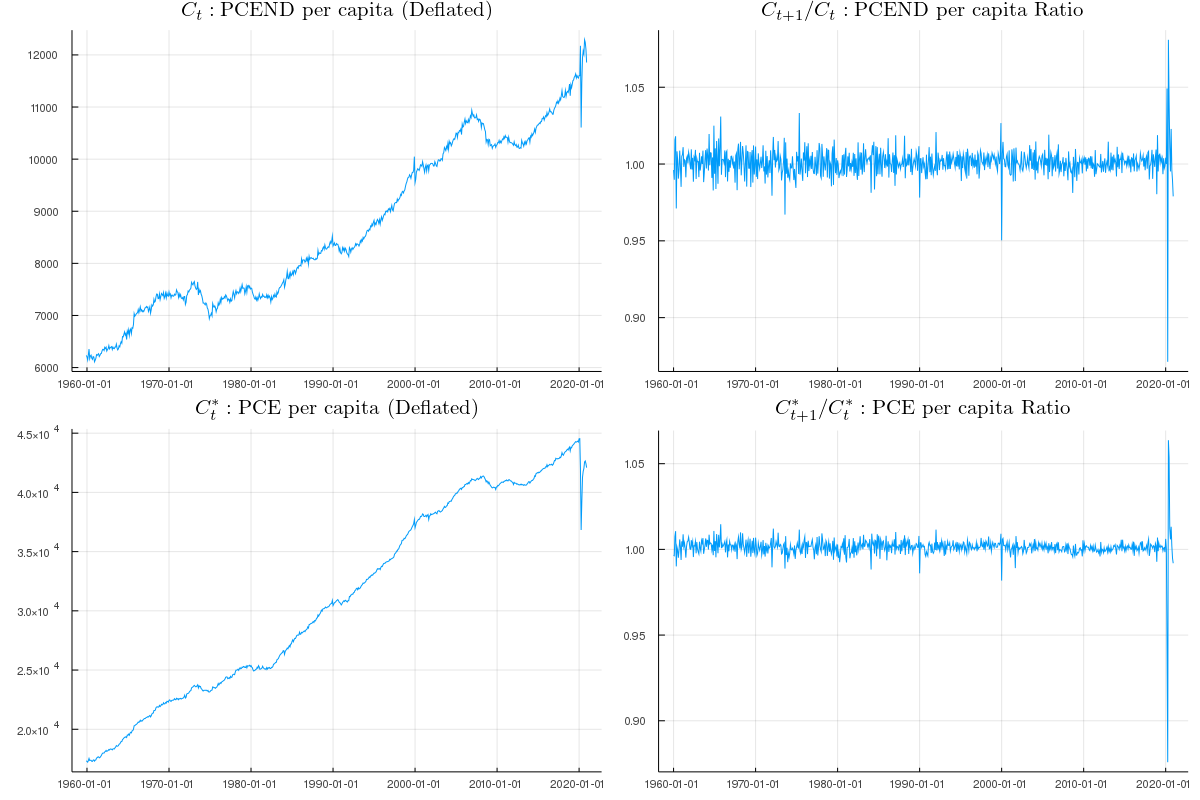

In [16]:
gr(fmt=png);
min_date = Dates.Date(1960,1,1)
max_date = Dates.Date(2020,12,1)
p1 = plot(rPCENDpc,label="",
          title=L"C_{t}: \textrm{PCEND per capita (Deflated)}",
          xlims = Dates.value.([min_date, max_date]),
          xticks= min_date:Year(10):max_date)
p2 = plot(rPCENDpcRatio,label="",
          title=L"C_{t+1}/C_{t}: \textrm{PCEND per capita Ratio}",
          xlims = Dates.value.([min_date, max_date]),
          xticks= min_date:Year(10):max_date)
p3 = plot(rPCEpc,label="",
          title=L"C_{t}^{*}: \textrm{PCE per capita (Deflated)}",
          xlims = Dates.value.([min_date, max_date]),
          xticks= min_date:Year(10):max_date)
p4 = plot(rPCEpcRatio,label="",
          title=L"C_{t+1}^{*}/C_{t}^{*}: \textrm{PCE per capita Ratio}",
          xlims = Dates.value.([min_date, max_date]),
          xticks= min_date:Year(10):max_date)
fig_c=plot(p1, p2, p3, p4, layout = @layout([p1 p3; p2 p4]), label=["" ""],size=(1200,800))

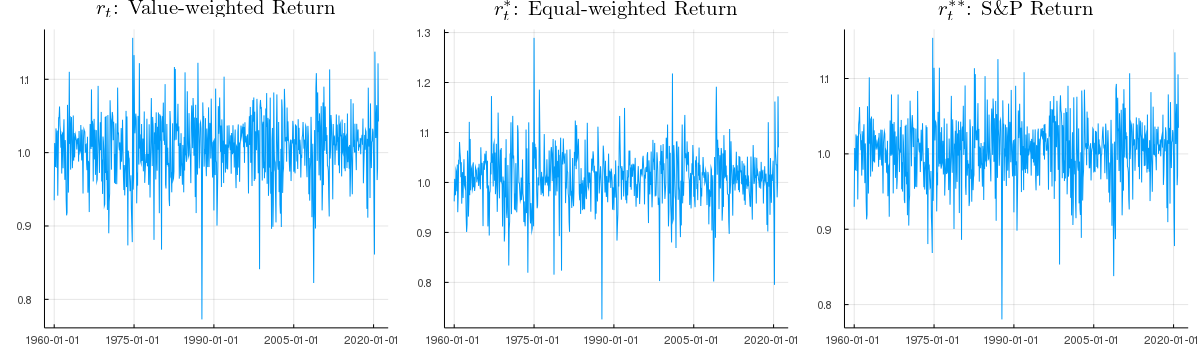

In [17]:
p1 = plot(rVWRETD,label="",
          title=L"r_{t} \textrm{: Value-weighted Return}",
          xlims = Dates.value.([min_date, max_date]),
          xticks= min_date:Year(15):max_date)
p2 = plot(rEWRETD,label="",
          title=L"r_{t}^{*} \textrm{: Equal-weighted Return}",
          xlims = Dates.value.([min_date, max_date]),
          xticks= min_date:Year(15):max_date)
p3 = plot(rSPRTRN,label="",
          title=L"r_{t}^{**} \textrm{: S\&P Return}",
          xlims = Dates.value.([min_date, max_date]),
          xticks= min_date:Year(15):max_date)
fig_r=plot(p1, p2, p3, layout = @layout([p1 p2 p3]), label=["" ""],size=(1200,360))

#### Question 2. Replicate the two panels of Table III from Hansen and Singleton (1984) to the extent you can with their subsample (1960-1 to 1978.12) and the instruments they used.

Before we get into Table III, let's see how we would replicate Table I:

<img src="[Hansen,Singleton;1984;Ecma] ERRATA - Table I estimates for 1959.2 - 1978.12.png">

Let's consider the first line. We are using NDS, EWR, in the moment function and one their lagged terms as instruments.
$$
\mathbb{E}\left[\begin{pmatrix} 1\\ \frac{c_t^{*}}{c_{t-1}^{*}}\\ r_{t}^{*} \end{pmatrix} 
    \cdot \left(r_{t+1}^{*}\beta\left(\frac{c_{t+1}^{*}}{c_t^{*}}\right)^{\alpha}-1\right)\right] = 0 \\
$$

In [18]:
# TABLE 1: EXAMPLE
# CONSUMPTION: NDS
# RETURN:      EWR
# NLAG:        1

C⃰ = values(rPCEpcRatio)[2:end];
r⃰ = values(rEWRETD)[2:end];
X = [C⃰ r⃰]; # N×2 matrix

C⃰_L1 = values(lag(rPCEpcRatio,1,padding=false))[1:end];
r⃰_L1 = values(lag(rEWRETD,1,padding=false))[1:end];
Z = [ones(length(C⃰_L1)) C⃰_L1 r⃰_L1]; # N×l matrix

function f_HS_TABLE1_EXAMPLE(γ, y, X, Z)
    #= 
    γ: parameters. γ[1]=α, γ[2]=β
    X: the matrix of variables that forms moments we wish to make 0
    Z: the matrix orthogonal to moment
    We want to have a N×3 vector
    =#
    C⃰, r⃰ = X[:,1], X[:,2]
    return (r⃰ .* γ[2] .* C⃰.^γ[1] .- y) .* Z # (N×1) ⊗ (N×3)
end;
γ_GMM, σ_GMM, chi2_vec, df, pval_vec, diff_vec = iterated_GMM(f_HS_TABLE1_EXAMPLE, rand(2), ones(length(C⃰)), X, Z; tol=1e-8, max_iter=100);

Note that the code returns p-values as `pval_vec`, not **"Prob"**. In Hansen and Singleton (1982), they reported (1-p-value) in the Prob column.

In [19]:
print("Hansen-Singleton GMM Replication: Table I \n")
print("Instrument Variable Estimates for the Period 1960:1 to 2020:12 \n")
print("One-step GMM \n")
print("Consumption | Return | NLAG |    α    |   se(α)   |    β    |   se(α)   |   χ²   | DF | p-value ||\n")
@printf("NDS         | EWR    | 1    | %7.4f | (%7.5f) | %7.4f | (%7.5f) | %6.4f | %2i | %6.4f  ||\n", 
        γ_GMM[1][1], σ_GMM[1][1],γ_GMM[1][2], σ_GMM[1][2], chi2_vec[1], df, pval_vec[1])

Hansen-Singleton GMM Replication: Table I 
Instrument Variable Estimates for the Period 1960:1 to 2020:12 
One-step GMM 
Consumption | Return | NLAG |    α    |   se(α)   |    β    |   se(α)   |   χ²   | DF | p-value ||
NDS         | EWR    | 1    | -6.8159 | (4.22983) |  0.9989 | (0.00609) | 0.0000 |  1 | 0.9984  ||


In [20]:
print("Hansen-Singleton GMM Replication: Table I \n")
print("Instrument Variable Estimates for the Period 1960:1 to 2020:12 \n")
print("Two-step GMM \n")
print("Consumption | Return | NLAG |    α    |   se(α)   |    β    |   se(α)   |   χ²   | DF |  p-value ||\n")
@printf("NDS         | EWR    | 1    | %7.4f | (%7.5f) | %7.4f | (%7.5f) | %6.4f | %2i |  %6.4f  ||\n", 
        γ_GMM[2][1], σ_GMM[2][1], γ_GMM[2][2], σ_GMM[2][2], chi2_vec[2], df, pval_vec[2])

Hansen-Singleton GMM Replication: Table I 
Instrument Variable Estimates for the Period 1960:1 to 2020:12 
Two-step GMM 
Consumption | Return | NLAG |    α    |   se(α)   |    β    |   se(α)   |   χ²   | DF |  p-value ||
NDS         | EWR    | 1    | -7.8849 | (4.39516) |  1.0011 | (0.00596) | 1.3001 |  1 |  0.2542  ||


In [21]:
print("Hansen-Singleton GMM Replication: Table I \n")
print("Instrument Variable Estimates for the Period 1960:1 to 2020:12 \n")
print("Iterated GMM until convergence with tolerance 1e-8 \n")
print("Consumption | Return | NLAG |    α    |   se(α)   |    β    |   se(α)   |   χ²   | DF |  p-value | Iteration ||\n")
@printf("NDS         | EWR    | 1    | %7.4f | (%7.5f) | %7.4f | (%7.5f) | %6.4f | %2i |  %6.4f  | %5i     ||\n", 
        γ_GMM[end][1], σ_GMM[end][1], γ_GMM[end][2], σ_GMM[end][2], chi2_vec[end], df, pval_vec[end], size(γ_GMM)[1])

Hansen-Singleton GMM Replication: Table I 
Instrument Variable Estimates for the Period 1960:1 to 2020:12 
Iterated GMM until convergence with tolerance 1e-8 
Consumption | Return | NLAG |    α    |   se(α)   |    β    |   se(α)   |   χ²   | DF |  p-value | Iteration ||
NDS         | EWR    | 1    | -8.2670 | (4.49937) |  1.0016 | (0.00606) | 0.8924 |  1 |  0.3448  |    16     ||


### Let's replicate Table III (Finally!)

<img src="[Hansen,Singleton;1984;Ecma] ERRATA - Table III estimates with multiple returns.png">

#### Panel A

There is one more complication here: we now have two sets of orthogonality conditions. The first line estimates of Table III uses equally- and value-weighted returns, with one lag for each of the consumption ration and equally- and value-weighted returns. This is a set of 8 population moment conditions in 2 parameters ($\alpha,\beta$).

$$
\begin{align*}
\mathbb{E}\left[\begin{pmatrix}
1\\ 
\frac{c_t}{c_{t-1}}\\ 
r_{t}^*\\ 
r_{t}
\end{pmatrix} \cdot \left(r_{t+1}^*\beta\left(\frac{c_{t+1}^*}{c_t^*}\right)^{\alpha}-1\right)\right] &= 0 \\
\mathbb{E}\left[\begin{pmatrix}
1\\ 
\frac{c_t}{c_{t-1}}\\ 
r_{t}^*\\ 
r_{t}
\end{pmatrix} \cdot \left(r_{t+1}\beta\left(\frac{c_{t+1}^*}{c_t^*}\right)^{\alpha}-1\right)\right] &= 0
\end{align*}
$$

The degree of freedom (DF) is 2*(1+(NLAG of consumption ratio)+(NLAG of EWR)+(NLAG of VWR))-2
- NLAG=1: $2\times(1+1+1+1)-2=6$
- NLAG=2: $2\times(1+2+2+2)-2=12$ 
- NLAG=4: $2\times(1+4+4+4)-2=24$

In [22]:
# TABLE 3: EXAMPLE
# CONSUMPTION: NDS
# RETURN: EWR & VWR
# NLAG: 1

C⃰ = values(rPCEpcRatio)[2:end];
r  = values(rVWRETD)[2:end];
r⃰ = values(rEWRETD)[2:end];
X = [C⃰ r r⃰];

C⃰_L1 = values(lag(rPCEpcRatio,1,padding=false));
r_L1  = values(lag(rVWRETD,1,padding=false));
r⃰_L1 = values(lag(rEWRETD,1,padding=false));
Z = [ones(length(C⃰_L1)) C⃰_L1 r_L1 r⃰_L1];

function f_HS_TABLE3_EXAMPLE(γ, y, X, Z)
    #= 
    γ: parameters. γ[1]=α, γ[2]=β
    X: the matrix of variables that forms moments we wish to make 0
    Z: the matrix orthogonal to moment
    We want to have a N×8 vector
    =#
    C⃰, r, r⃰ = X[:,1], X[:,2], X[:,3];
    m1 = (r⃰ .* γ[2] .* C⃰.^γ[1] - y) .* Z # (N×1) ⊗ (N×4)
    m2 = (r  .* γ[2] .* C⃰.^γ[1] - y) .* Z # (N×1) ⊗ (N×4)
    return [m1 m2]
end;

#### Panel B

In Hansen and Singleton (1984), they describe how they used the nominal risk-free returns:

<img src="[Hansen,Singleton;1984;Ecma] ERRATA - on nominal risk-free returns on Table III.png" width="700">

$$
\begin{align*}
\mathbb{E}\left[\begin{pmatrix}
1\\ 
\frac{c_t}{c_{t-1}}\\ 
r_{t}\\ 
\frac{R_{t+1}^f}{R_{t}^f}\\
\frac{R_{t}^f}{R_{t-1}^f}
\end{pmatrix} \cdot \left(r_{t+1}\beta\left(\frac{c_{t+1}^*}{c_t^*}\right)^{\alpha}-1\right)\right] &= 0 \\
\mathbb{E}\left[\begin{pmatrix}
1\\ 
\frac{c_t}{c_{t-1}}\\ 
r_t \\
\frac{R_{t+1}^f}{R_{t}^f}\\
\frac{R_{t}^f}{R_{t-1}^f}
\end{pmatrix} \cdot \left(R_{t+1}^f \beta\left(\frac{c_{t+1}}{c_t}\right)^{\alpha}-1\right)\right] &= 0
\end{align*}
$$

Their claim is that the degree of freedom is 2* [constant + (risk-free ratio + NLAG for risk-free ratio) + (NLAG for consumption ratio) + (NLAG for VWR)]-2
- NLAG=1: $2\times(1+(1+1)+1+1)-2=8$
- NLAG=2: $2\times(1+(1+2)+2+2)-2=14$
- NLAG=4: $2\times(1+(1+4)+4+4)-2=26$

(Credit to Christine Dabbs) However, it seems like Hansen and Singleton double-counted the number of risk-free ratios. They have df = 8, 16, 32. These numbers are replicable if we counted degree of freedoms as:

2* [constant + 2*(NLAG for risk-free ratio) + (NLAG for consumption ratio) + (NLAG for VWR)]-2
- NLAG=1: $2\times(1+2*1+1+1)-2=8$
- NLAG=2: $2\times(1+2*2+2+2)-2=16$
- NLAG=4: $2\times(1+2*4+4+4)-2=32$

#### Question 3

Here, you are now estimating 4 parameters, $(\alpha_1,\beta_1,\alpha_2,\beta_2)$. You may want to find $(\alpha_1,\beta_1)$ only with data from 1960.1 to 1978.12 and $(\alpha_2,\beta_2)$ with data from 1979.1 and onward. You can change `f_HS_TABLE3_EXAMPLE` to do this exercise. You can only use data from 1960.1 to 1978.12 for `m1` and use data from 1979.1 to 2020.12 for `m2`. You may also want to use $4\times1$ vector $\vec{\gamma}$. This is your 'unconstrained' GMM.

Now, you are asked to test $(\alpha_1,\beta_1)=(\alpha_2,\beta_2)$. The following theorem will be helpful:

#### Theorem ([Professor Miller's Lecture Notes, slide 17](https://comlabgames.com/structuraleconometrics/3%20Asymptotic%20Theory%20for%20Nonlinear%20Models/13%20Testing%20Parametric%20Models/13%20Testing%20Parametric%20Models.pdf))
Let $J_{un}$ be the unconstrained GMM criterion function with $l_1$ orthogonality conditions and $k_1$ parameters. Let $J_{con}$ be the constrained GMM criterion function with $l_2$ orthogonality conditions and $k_2$ parameters. Then,
$$
J_{con} - J_{un} \overset{d}{\longrightarrow} \chi^2_{(l_2-k_2)-(l_1-k_1)}.
$$

Additionally, you might be able to test models with more parameters in more time frames, say, before/after the financial crisis in 2008 and before/after COVID-19. To do so, you may need more instruments using more lagged variables.

#### Question 4 and 5
I will leave questions 4 and 5 for you to explore. Now you have basic codes to run, I am sure you can easily modify code and get the estimates.

#### Question 6

Let’s come back to data and think about big picture here. Hansen and Singleton (1982) assumes that we have a stationary environment. Test whether any of these series we considered in question 1 have a unit root. (You should read about [unit root tests](https://en.wikipedia.org/wiki/Unit_root_test) first.) Is there evidencethat these series are not stationary and ergodic?

I use [Augmented Dickey-Fuller (ADF) Test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). I will let you discuss whether you think time series data we used are stationary and ergodic.

(Not graded) TA's conjecture: Try ADF tests with i) a constant, ii) a trend, iii) a trend and trend squared. What do these tests tell you? If Hansen and Singleton (1982) requires stationarity, how would you incorporate the findings to your model?

In [23]:
varDF = DataFrame(varname=Vector{String}(),
                varsymbol=Vector{Symbol}(),
                vardata=Vector{TimeArray}())
varDF=vcat(varDF,DataFrame(varname="PCE per Capita (deflated)",varsymbol=:rPCEpc,vardata=rPCEpc))
varDF=vcat(varDF,DataFrame(varname="PCEND per Capita (deflated)",varsymbol=:rPCENDpc,vardata=rPCENDpc))
varDF=vcat(varDF,DataFrame(varname="PCE per Capita (deflated) ratio",varsymbol=:rPCEpcRatio,vardata=rPCEpcRatio))
varDF=vcat(varDF,DataFrame(varname="PCEND per Capita (deflated) ratio",varsymbol=:rPCENDpcRatio,vardata=rPCENDpcRatio))
varDF=vcat(varDF,DataFrame(varname="Real Equal-weighted Returns",varsymbol=:rEWRETD,vardata=rEWRETD))
varDF=vcat(varDF,DataFrame(varname="Real Value-Weighted Returns",varsymbol=:rVWRETD,vardata=rVWRETD))
varDF=vcat(varDF,DataFrame(varname="Real S&P Returns",varsymbol=:rSPRTRN,vardata=rSPRTRN))
for i in 1:4
    name = varDF[:varname][i]
    symbol = varDF[:varsymbol][i]
    data = varDF[:vardata][i]
    data = DataFrame(data)[!,symbol][2:end]
    print("ADF Test: $name \n")
    print("        | Coefficient |  Statistic  | p-value | \n")
    for lags = [1,2,4,6]
        stat = ADFTest(data, :none, lags).stat
        coef = ADFTest(data, :none, lags).coef
        pval = pvalue(ADFTest(data, :none, lags))
        print("NLAGS:$lags |")
        @printf(" %11.8f | %11.8f |  %6.4f | \n", coef, stat, pval)
    end
    print("\n")
end

ADF Test: PCE per Capita (deflated) 
        | Coefficient |  Statistic  | p-value | 
NLAGS:1 |  0.00082504 |  2.68999136 |  0.9991 | 
NLAGS:2 |  0.00111050 |  3.77509210 |  1.0000 | 
NLAGS:4 |  0.00126308 |  4.20316638 |  1.0000 | 
NLAGS:6 |  0.00150265 |  4.89041064 |  1.0000 | 

ADF Test: PCEND per Capita (deflated) 
        | Coefficient |  Statistic  | p-value | 
NLAGS:1 |  0.00127625 |  3.46390719 |  1.0000 | 
NLAGS:2 |  0.00163299 |  4.52478203 |  1.0000 | 
NLAGS:4 |  0.00172814 |  4.64060820 |  1.0000 | 
NLAGS:6 |  0.00185559 |  4.81083390 |  1.0000 | 

ADF Test: PCE per Capita (deflated) ratio 
        | Coefficient |  Statistic  | p-value | 
NLAGS:1 | -0.00005177 | -0.15640896 |  0.6299 | 
NLAGS:2 | -0.00004816 | -0.15977659 |  0.6287 | 
NLAGS:4 | -0.00002029 | -0.07191133 |  0.6598 | 
NLAGS:6 |  0.00002494 |  0.09237961 |  0.7142 | 

ADF Test: PCEND per Capita (deflated) ratio 
        | Coefficient |  Statistic  | p-value | 
NLAGS:1 | -0.00009836 | -0.21213387 |  0.6094 | 


In [24]:
for i in 5:size(varDF)[1]
    name = varDF[:varname][i]
    symbol = varDF[:varsymbol][i]
    data = varDF[:vardata][i]
    data = DataFrame(data)[!,symbol][2:end]
    print("ADF Test: $name \n")
    print("        | Coefficient |  Statistic  | p-value | \n")
    for lags = [1,2,4,6]
        stat = ADFTest(data, :none, lags).stat
        coef = ADFTest(data, :none, lags).coef
        pval = pvalue(ADFTest(data, :none, lags))
        print("NLAGS:$lags |")
        @printf(" %11.8f | %11.8f |  %6.4f | \n", coef, stat, pval)
    end
    print("\n")
end

ADF Test: Real Equal-weighted Returns 
        | Coefficient |  Statistic  | p-value | 
NLAGS:1 | -0.00132300 | -0.55006565 |  0.4754 | 
NLAGS:2 | -0.00079871 | -0.34893611 |  0.5570 | 
NLAGS:4 | -0.00043818 | -0.19989517 |  0.6139 | 
NLAGS:6 | -0.00026727 | -0.12372051 |  0.6416 | 

ADF Test: Real Value-Weighted Returns 
        | Coefficient |  Statistic  | p-value | 
NLAGS:1 | -0.00087629 | -0.43629336 |  0.5221 | 
NLAGS:2 | -0.00047376 | -0.25226713 |  0.5943 | 
NLAGS:4 | -0.00025317 | -0.14269892 |  0.6348 | 
NLAGS:6 | -0.00013912 | -0.07952131 |  0.6572 | 

ADF Test: Real S&P Returns 
        | Coefficient |  Statistic  | p-value | 
NLAGS:1 | -0.00082537 | -0.42158358 |  0.5280 | 
NLAGS:2 | -0.00043731 | -0.24014009 |  0.5989 | 
NLAGS:4 | -0.00022674 | -0.13262534 |  0.6384 | 
NLAGS:6 | -0.00012748 | -0.07545528 |  0.6586 | 



References:
- [Professor Miller's Lecture Note Chapters 3 and 12](https://comlabgames.com/structuraleconometrics/)
- [Bruce Hansen's econometrics textbook](https://www.ssc.wisc.edu/~bhansen/econometrics/Econometrics.pdf)
- Hansen, Lars Peter, and Kenneth J. Singleton. "Generalized instrumental variables estimation of nonlinear rational expectations models." Econometrica: Journal of the Econometric Society (1982): 1269-1286.
- Hansen, Lars Peter. "Large sample properties of generalized method of moments estimators." Econometrica: Journal of the econometric society (1982): 1029-1054.
- Newey, Whitney K., and Daniel McFadden. "Large sample estimation and hypothesis testing." Handbook of econometrics 4 (1994): 2111-2245.